<a href="https://colab.research.google.com/github/srikarraju/GridWorld/blob/main/GARNET_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
num_states =  8
num_actions = 3
branching_factor = 2
std_dev = 0.1
deg_non_stat = 0

In [ ]:
import numpy as np
from numpy.random import default_rng

rng = default_rng()
possible_next_states = []
for i in range(num_states):
  state_next_states = []
  for j in range(num_actions):
    next_states = rng.choice(num_states, size=branching_factor, replace=False)
    state_next_states.append(next_states[:])
  possible_next_states.append(state_next_states)

possible_next_states = np.asarray(possible_next_states)
print(possible_next_states.shape)

trans_probs = []

for i in range(num_states):
  state_probs = []
  for j in range(num_actions):
    intervals = np.random.uniform(size = branching_factor - 1)
    #print(intervals)
    intervals.sort()
    state_action_probs = []
    state_action_probs.append(intervals[0])
    for k in range(branching_factor-2):
      state_action_probs.append(intervals[k+1]-intervals[k])
    state_action_probs.append(1 - intervals[branching_factor - 2])
    state_probs.append(state_action_probs)
  trans_probs.append(state_probs)

trans_probs = np.asarray(trans_probs)
print(trans_probs.shape)

rewards_mean = []

for i in range(num_states):
  state_rewards = []
  for j in range(num_actions):
    state_action_rewards = []
    for k in range(branching_factor):
      state_action_rewards.append(np.random.normal(0,1))
    state_rewards.append(state_action_rewards)
  rewards_mean.append(state_rewards)

rewards_mean = np.asarray(rewards_mean)
print(rewards_mean.shape)

def take_action(state,action):
  next_possible_states = possible_next_states[state][action]
  next_state_probs = trans_probs[state][action]

  #print(next_possible_states,next_state_probs)

  next_state_index = np.random.choice(a = np.arange(branching_factor), p = next_state_probs)
  next_state = possible_next_states[state][action][next_state_index]
  reward_mean = rewards_mean[state][action][next_state_index]

  #print(reward_mean)

  actual_reward = np.random.normal(reward_mean,std_dev)

  return next_state, reward_mean

print(take_action(2,1))

(8, 3, 2)
(8, 3, 2)
(8, 3, 2)
(7, 0.8548946850351196)


In [ ]:
import numpy as np
from numpy.random import default_rng

rng = default_rng()

def generate_state_features(num_states,d,l):
  state_features = []
  product_dict = {}
  while len(state_features) < num_states:
    one_indices = rng.choice(d, size = l, replace=False)
    product = 1
    for i in range(l):
      product *= one_indices[i]
    feature_vec = np.zeros(d)
    if product not in product_dict:
      for index in one_indices:
        feature_vec[index] = 1
      state_features.append(feature_vec)
      product_dict[product] = 1
  #print(len(product_dict))
  return state_features

#print(np.asarray(generate_state_features(num_states,8,3)))

In [ ]:
def generate_state_action_features(state_vec, d, num_actions):
  state_action_features = np.zeros(shape=(num_actions,d*num_actions))
  for i in range(num_actions):
    for j in range(d):
      state_action_features[i][d*i+j] = state_vec[j]
  return state_action_features

#print(generate_state_action_features([1,0,0,1,0,0,1,1],8,4))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
from collections import deque
import numpy as np

In [ ]:
returns = deque(maxlen=100)

d, l = 8, 3

weights_v = np.zeros(d,dtype=float)
weights_p = np.zeros(d*num_actions,dtype=float)
rewards2 = []

print(weights_v)
print(weights_p)

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#ALGORITHM 1
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 100000
t = 0
n_episode = 1
actions_list = []
avg_reward = 0

state_features = generate_state_features(num_states,d,l)

while n_episode <=10000:
  rewards,states,actions = [],[],[]
  state = 0

  episode_len = 0
  while episode_len<=50:
    episode_len += 1
    state_action_features = generate_state_action_features(state_features[state],d,num_actions)
    t += 1

    probs = np.dot(weights_p,np.transpose(state_action_features))
    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()
    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward = take_action(state,action)

    value_curr = np.dot(weights_v,np.asarray(state_features[state]))
    value_next = np.dot(weights_v,np.asarray(state_features[new_state]))

    beta = (beta_0 * beta_c) / (beta_c + n_episode)
    alpha = (alpha_0 * alpha_c) / (alpha_c + n_episode**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward
    td_error = reward + value_next - value_curr - avg_reward

    weights_v += 0.005*alpha * (abs(td_error)/td_error) * np.asarray(state_features[state])
    weights_p += 0.005*beta * (abs(td_error)/td_error) * probs[action] * (1 - probs[action]) * state_action_features[action]


    states.append(state)
    actions.append(action)
    rewards.append(reward)
    actions_list.append(action)

    state = new_state

  returns.append(np.sum(rewards))
  #print(np.sum(rewards))
  if n_episode%100==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  rewards1.append(np.mean(returns))
  n_episode += 1

Episode:    100	Avg. Return:  11.95
Episode:    200	Avg. Return:  13.78
Episode:    300	Avg. Return:  14.72
Episode:    400	Avg. Return:  17.47
Episode:    500	Avg. Return:  17.26
Episode:    600	Avg. Return:  18.41
Episode:    700	Avg. Return:  21.70
Episode:    800	Avg. Return:  21.91
Episode:    900	Avg. Return:  25.21
Episode:   1000	Avg. Return:  25.17
Episode:   1100	Avg. Return:  26.80
Episode:   1200	Avg. Return:  27.95
Episode:   1300	Avg. Return:  28.09
Episode:   1400	Avg. Return:  28.78
Episode:   1500	Avg. Return:  31.60
Episode:   1600	Avg. Return:  30.56
Episode:   1700	Avg. Return:  33.35
Episode:   1800	Avg. Return:  32.05
Episode:   1900	Avg. Return:  34.41
Episode:   2000	Avg. Return:  34.46
Episode:   2100	Avg. Return:  35.55
Episode:   2200	Avg. Return:  36.93
Episode:   2300	Avg. Return:  36.44
Episode:   2400	Avg. Return:  37.34
Episode:   2500	Avg. Return:  38.51
Episode:   2600	Avg. Return:  38.21
Episode:   2700	Avg. Return:  38.39
Episode:   2800	Avg. Return:

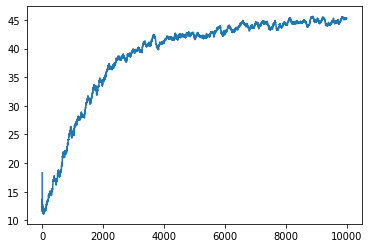

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards1[20000:])
plt.show()

In [ ]:
weights_w = np.zeros(d*num_actions,dtype=float)

alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 100000
t = 0
n_episode = 1
actions_list = []
avg_reward = 0
state_features = generate_state_features(num_states,d,l)

while n_episode <=10000:
  rewards,states,actions = [],[],[]
  state = 0
  episode_len = 0
  while episode_len<=50:
    episode_len += 1
    state_action_features = generate_state_action_features(state_features[state],d,num_actions)
    t += 1

    probs = np.dot(weights_p,np.transpose(state_action_features))

    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()
    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward = take_action(state,action)

    value_curr = np.dot(weights_v,np.asarray(state_features[state]))
    value_next = np.dot(weights_v,np.asarray(state_features[new_state]))

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward
    td_error = reward + value_next - value_curr - avg_reward

    weights_v += alpha * td_error * np.asarray(state_features[state])

    grad_prob = (1 - probs[action]) * np.asarray(state_action_features[action])

    weights_w = np.dot(np.eye(grad_prob.size) - alpha * np.outer(grad_prob, grad_prob), weights_w)
    weights_w += alpha * td_error * grad_prob
    weights_p += 0.1*beta * weights_w

    states.append(state)
    actions.append(action)
    rewards.append(reward)
    actions_list.append(action)

    state = new_state
  returns.append(np.sum(rewards))
  #print(np.sum(rewards))
  if n_episode%50==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  rewards2.append(np.mean(returns))
  n_episode += 1

Episode:     50	Avg. Return:  46.36
Episode:    100	Avg. Return:  48.80
Episode:    150	Avg. Return:  50.67
Episode:    200	Avg. Return:  49.94
Episode:    250	Avg. Return:  50.18
Episode:    300	Avg. Return:  49.89
Episode:    350	Avg. Return:  49.32
Episode:    400	Avg. Return:  49.58
Episode:    450	Avg. Return:  50.71
Episode:    500	Avg. Return:  50.97
Episode:    550	Avg. Return:  50.29
Episode:    600	Avg. Return:  49.96
Episode:    650	Avg. Return:  50.29
Episode:    700	Avg. Return:  50.04
Episode:    750	Avg. Return:  49.87
Episode:    800	Avg. Return:  50.27
Episode:    850	Avg. Return:  49.78
Episode:    900	Avg. Return:  49.69
Episode:    950	Avg. Return:  50.55
Episode:   1000	Avg. Return:  50.52
Episode:   1050	Avg. Return:  49.11
Episode:   1100	Avg. Return:  49.98
Episode:   1150	Avg. Return:  51.58


KeyboardInterrupt: ignored

In [ ]:
returns = deque(maxlen=100)

d, l = 8, 3

weights_v = np.zeros(d,dtype=float)
weights_p = np.zeros(d*num_actions,dtype=float)
rewards2 = []

print(weights_v)
print(weights_p)

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#ALGORITHM 4
weights_w = np.zeros(d*num_actions,dtype=float)

alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 100000
t = 0
n_episode = 1
actions_list = []
avg_reward = 0
state_features = generate_state_features(num_states,d,l)
fischer_inv = 2.5*np.eye(d*num_actions)

while n_episode <=10000:
  rewards,states,actions = [],[],[]
  state = 0
  episode_len = 0
  while episode_len<=50:
    episode_len += 1
    state_action_features = generate_state_action_features(state_features[state],d,num_actions)
    t += 1

    probs = np.dot(weights_p,np.transpose(state_action_features))

    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()
    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward = take_action(state,action)

    value_curr = np.dot(weights_v,np.asarray(state_features[state]))
    value_next = np.dot(weights_v,np.asarray(state_features[new_state]))

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward
    td_error = reward + value_curr - value_next - avg_reward

    weights_v += alpha * td_error * np.asarray(state_features[state])

    grad_prob = (1-probs[action])*state_action_features[action]

    Gt_psi_dot = np.dot(fischer_inv, grad_prob)
    fischer_inv -= (0.001*alpha * np.outer(Gt_psi_dot,Gt_psi_dot) ) / (1 - 0.001*alpha + 0.001*alpha * np.dot(Gt_psi_dot,grad_prob))
    fischer_inv /= (1 - 0.0001*alpha)
    weights_w = (1- alpha) *weights_w + alpha* td_error * np.dot(fischer_inv,grad_prob)

    weights_p += beta * weights_w

    states.append(state)
    actions.append(action)
    rewards.append(reward)
    actions_list.append(action)

    state = new_state
  returns.append(np.sum(rewards))
  #print(np.sum(rewards))
  if n_episode%100==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  n_episode += 1

Episode:    100	Avg. Return:  -6.74
Episode:    200	Avg. Return: -10.41
Episode:    300	Avg. Return: -12.43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


IndexError: ignored

In [ ]:
print(states)
print(actions)
print(rewards)

[0, 3, 5]
[2, 0, 0]
[0.5217193225237641, 0.151378240040636, 5.079021754702377]


In [ ]:
print(rewards_mean)

[[[-0.25061534  1.49539764]
  [-0.30208198 -0.25410217]
  [-0.81584873 -0.10771639]]

 [[-0.29835569  0.2072118 ]
  [-0.04707335  0.70120915]
  [-0.08716664 -1.5916152 ]]

 [[ 1.18149004  1.65736056]
  [ 0.86636364  2.41890358]
  [ 0.52071488  0.169385  ]]

 [[ 0.05366395  1.01816619]
  [ 0.07552728 -0.87560103]
  [-0.24413793 -1.38707909]]

 [[ 0.58504293 -0.48438896]
  [ 0.20450839  0.01599129]
  [ 0.35469568 -1.0449963 ]]

 [[ 0.13948531  0.06054098]
  [-0.10047899  0.00675582]
  [-0.25366147 -0.32085055]]

 [[ 1.9270511   1.44741449]
  [-0.03075387 -1.1259968 ]
  [ 0.49338175 -1.30633275]]

 [[-0.08173137 -1.79330266]
  [-1.86448101  1.17835433]
  [-0.56688518 -0.75269304]]]


In [ ]:
print(possible_next_states)

[[[2 5]
  [3 6]
  [7 3]]

 [[0 1]
  [4 6]
  [4 2]]

 [[0 3]
  [0 1]
  [6 7]]

 [[5 7]
  [5 1]
  [4 0]]

 [[2 5]
  [0 3]
  [1 6]]

 [[7 4]
  [7 4]
  [6 5]]

 [[2 1]
  [6 0]
  [1 2]]

 [[5 0]
  [0 4]
  [2 1]]]


In [ ]:
print(trans_probs)

[[[0.91225281 0.08774719]
  [0.482354   0.517646  ]
  [0.23483585 0.76516415]]

 [[0.05053881 0.94946119]
  [0.93053987 0.06946013]
  [0.45078013 0.54921987]]

 [[0.11012645 0.88987355]
  [0.17111131 0.82888869]
  [0.42087916 0.57912084]]

 [[0.80255451 0.19744549]
  [0.66564375 0.33435625]
  [0.03601308 0.96398692]]

 [[0.03296661 0.96703339]
  [0.74041548 0.25958452]
  [0.36689571 0.63310429]]

 [[0.50273818 0.49726182]
  [0.53316924 0.46683076]
  [0.63097928 0.36902072]]

 [[0.86964531 0.13035469]
  [0.31619094 0.68380906]
  [0.34287114 0.65712886]]

 [[0.28173449 0.71826551]
  [0.35949537 0.64050463]
  [0.94689102 0.05310898]]]
